## Import Necessary Modules

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from maddpg_agent import Agent
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

## Unity Tennis Environment

- Choose your environment appropriately from the `environment` folder

In [2]:
env = UnityEnvironment(file_name="Tennis.app", worker_id=8)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.38993645 -1.5
 -0.          0.          6.83172083  5.99607611 -0.          0.        ]


## Random Agent

In [9]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode: {:d}\tMax reward: {:2.3f}'.format(i+1, np.max(scores)))

Episode: 1	Max reward: 0.000
Episode: 2	Max reward: 0.000
Episode: 3	Max reward: 0.000
Episode: 4	Max reward: 0.100
Episode: 5	Max reward: 0.000


## MADDPG

- Utility Function

In [23]:
def save_model(agent, en):
    torch.save(agent.actor_local.state_dict(), 'checkpointv3_extended_actor_agent'+str(en)+'.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpointv3_extended_critic_agent'+str(en)+'.pth')

### Initialize the agents

In [9]:
agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)

In [14]:
def maddpg(n_episodes=10000, print_every=50, save_every=100):
    
    scores_deque = deque(maxlen=100)
    fullscores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        states = np.reshape(states, (1, 48))
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            action0 = agent_0.act(states, add_noise=True)
            action1 = agent_1.act(states, add_noise=True)
            actions = np.concatenate((action0, action1), axis=0)
            actions = np.reshape(actions, (1, 4))
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            next_states = np.reshape(next_states, (1, 48))
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent_0.step(states, actions, rewards[0], next_states, dones[0], 0)
            agent_1.step(states, actions, rewards[1], next_states, dones[1], 1)
            scores += rewards
            states = next_states
            
            if np.any(dones):
                break
                
        scores_deque.append(np.max(scores))
        fullscores.append(np.max(scores))
        average_score = np.mean(scores_deque)
        
        print('\rEpisode: {}\tMax Reward: {:2.3f}\tAverage (Max) Reward: {:2.3f}'.format(i_episode, np.max(scores),
                                                                                        average_score), end="")
        if i_episode % print_every == 0:
            print()
        
        if i_episode % save_every == 0:
            save_model(agent_0, 0)
            save_model(agent_1, 1)
            
        if average_score >= 0.5:
            print('Environment solved in {:d} episodes!\tAverage Reward: {:2.3f}'.format(i_episode-100, average_score))
            save_model(agent_0, 0)
            save_model(agent_1, 1)
            break
    
    return scores_deque, fullscores
        

In [15]:
scores_deque, fullscores = maddpg()

Episode: 50	Max Reward: 0.090	Average (Max) Reward: 0.042
Episode: 100	Max Reward: 0.000	Average (Max) Reward: 0.043
Episode: 150	Max Reward: 0.000	Average (Max) Reward: 0.039
Episode: 200	Max Reward: 0.100	Average (Max) Reward: 0.046
Episode: 250	Max Reward: 0.000	Average (Max) Reward: 0.055
Episode: 300	Max Reward: 0.000	Average (Max) Reward: 0.058
Episode: 350	Max Reward: 0.100	Average (Max) Reward: 0.080
Episode: 400	Max Reward: 0.100	Average (Max) Reward: 0.106
Episode: 450	Max Reward: 0.200	Average (Max) Reward: 0.154
Episode: 500	Max Reward: 0.200	Average (Max) Reward: 0.198
Episode: 550	Max Reward: 0.300	Average (Max) Reward: 0.245
Episode: 600	Max Reward: 0.100	Average (Max) Reward: 0.353
Episode: 650	Max Reward: 1.200	Average (Max) Reward: 0.502
Environment solved in 550 episodes!	Average Reward: 0.502


In [19]:
average_scores = []
temp_deque = deque(maxlen=100)
for s in fullscores:
    temp_deque.append(s)
    average_scores.append(np.mean(temp_deque))

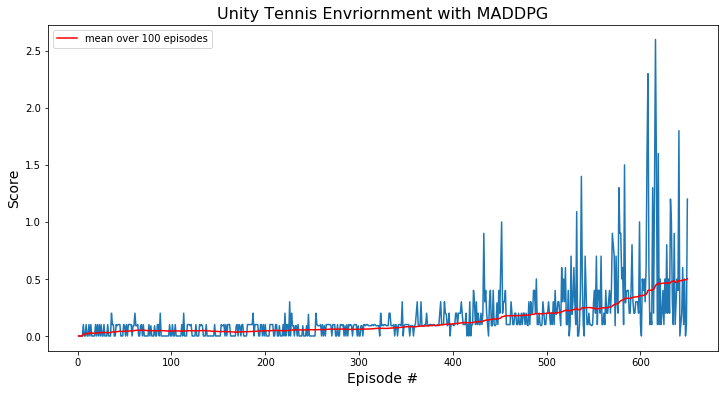

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(fullscores)+1), fullscores)
ax.plot(range(1, len(average_scores)+1), average_scores, c='r', label='mean over 100 episodes')
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Unity Tennis Envriornment with MADDPG', fontsize=16)
plt.legend()
plt.show()

In [28]:
env.close()

## Evaluation

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from maddpg_agent import Agent
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Tennis.app", worker_id=8)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

In [5]:
agent_0 = Agent(state_size, action_size, 1, random_seed=0, actor_filename='checkpoint_actor_agent0.pth', 
                critic_filename='checkpoint_critic_agent0.pth')
agent_1 = Agent(state_size, action_size, 1, random_seed=0, actor_filename='checkpoint_actor_agent1.pth',
               critic_filename='checkpoint_critic_agent1.pth')

## Iteration 1

In [6]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
states = np.reshape(states, (1, 48))
agent_0.reset()
agent_1.reset()
scores = np.zeros(num_agents)
while True:
    action0 = agent_0.act(states, add_noise=False)
    action1 = agent_1.act(states, add_noise=False)
    actions = np.concatenate((action0, action1), axis=0)
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    if np.any(dones):
        break
print('Max reward: {:2.3f}'.format(np.max(scores)))

Max reward: 2.600


## Iteration 2

In [10]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
states = np.reshape(states, (1, 48))
agent_0.reset()
agent_1.reset()
scores = np.zeros(num_agents)
while True:
    action0 = agent_0.act(states, add_noise=False)
    action1 = agent_1.act(states, add_noise=False)
    actions = np.concatenate((action0, action1), axis=0)
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    if np.any(dones):
        break
print('Max reward: {:2.3f}'.format(np.max(scores)))

Max reward: 0.800


## Iteration 3

In [8]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
states = np.reshape(states, (1, 48))
agent_0.reset()
agent_1.reset()
scores = np.zeros(num_agents)
while True:
    action0 = agent_0.act(states, add_noise=False)
    action1 = agent_1.act(states, add_noise=False)
    actions = np.concatenate((action0, action1), axis=0)
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    if np.any(dones):
        break
print('Max reward: {:2.3f}'.format(np.max(scores)))

Max reward: 1.400


## Iteration 4

In [7]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
states = np.reshape(states, (1, 48))
agent_0.reset()
agent_1.reset()
scores = np.zeros(num_agents)
while True:
    action0 = agent_0.act(states, add_noise=False)
    action1 = agent_1.act(states, add_noise=False)
    actions = np.concatenate((action0, action1), axis=0)
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    if np.any(dones):
        break
print('Max reward: {:2.3f}'.format(np.max(scores)))

Max reward: 0.600


## Iteration 5

In [11]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
states = np.reshape(states, (1, 48))
agent_0.reset()
agent_1.reset()
scores = np.zeros(num_agents)
while True:
    action0 = agent_0.act(states, add_noise=False)
    action1 = agent_1.act(states, add_noise=False)
    actions = np.concatenate((action0, action1), axis=0)
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    if np.any(dones):
        break
print('Max reward: {:2.3f}'.format(np.max(scores)))

Max reward: 2.600


In [12]:
env.close()